# Demo of NF-HEDM reconstruction using g-force

In [ ]:
# import os 
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [1]:
# run only once, otherwise GPU memory will not be collected correctly and cause memory leak.
# can also 'restart kernel' to clear out gpu memory
import numpy as np
import matplotlib.pyplot as plt
import pickle
# customized module

from hexomap import reconstruction  # g-force caller
from hexomap import MicFileTool     # io for reconstruction rst
from hexomap import IntBin          # io for binary image (reduced data)
from hexomap import config
#use 'nvidia-smi' in terminal to check gpu memory status
# create reconstructor that take data input and run reconstrution.
S = reconstruction.Reconstructor_GPU(gpuID=1) # use gpuID to choose which gpu to use

## Calibration with Au cube

integrate quaterdegree binary images into one degreee

> quater degree is harder to get geometry parameters


![Image of Yaktocat](https://www.andrew.cmu.edu/user/suter/3dxdm/schematic_web.jpg)
## illustrate how diffraction pattern are generated
1. pattern on second detector is slightly enlarged compared to first detector.

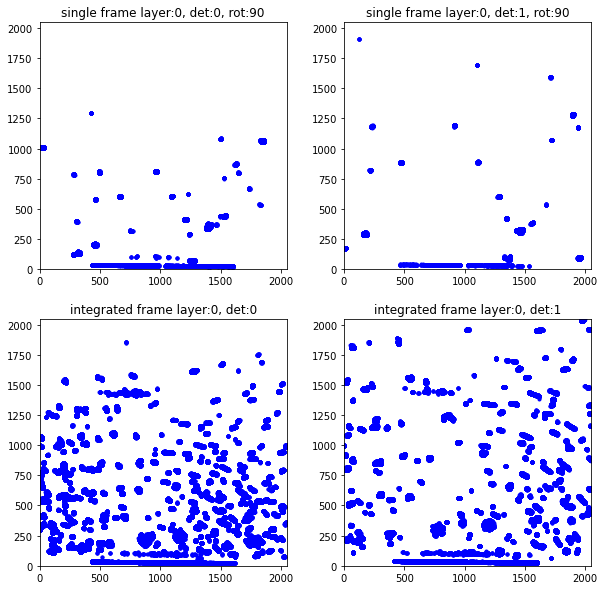

In [2]:
# check binary image
rawInitial = '../examples/johnson_aug18_demo/Au_reduced_1degree/Au_int_1degree_suter_aug18_z'
NRot = 50   # number of images to display, doen't have to be all images(no need set to 180 or 720.can be some thing like 10)
NDet = 2 # number of detector
idxLayer = 0 # which layer
idxRot = 90 # 
# %matplotlib inline
# plt.rcParams["figure.figsize"] = (15,10)
# show binary images.
MicFileTool.plot_binary(rawInitial, NRot=NRot, NDet=NDet, idxRot=idxRot,idxLayer=idxLayer)

# blind search for geometry parameters
1. parameters to search: detL, detJ, detK, detRot

1. other parameters are from experienment.

1. we need to specify a region that contain sample

1. only two detector distances could be optimized at once, 

e.g. if detector distances are [5.0,7.0,9.0,11.0,13.0], and you want to optimize the first 2 distances, use the following settings:

    'detL' : np.array([[5, 7]]),           # in mm, detector distance to sample rotation axis
    'fileBinDetIdx' : np.array([0, 1]),         # detector index,
    
if detector distances are [5.0,7.0,9.0,11.0,13.0], and you want to optimize the 7.0mm and 9.0mm distances, use the following settings:

    'detL' : np.array([[7, 9]]),           # in mm, detector distance to sample rotation axis
    'fileBinDetIdx' : np.array([1, 2]),         # detector index,

1. You must set the relative L correctly, the current optimization would move both L, so the relative distance would not change (remain dL=2mm if you set detL=[5,7])

In [3]:
Au_Config={
    'micsize' : np.array([20, 20]),          # resolution of recontruction, center at rotation center.
    'micVoxelSize' : 0.001,                  # in mm, pixel size, or distance between reconstrucition voxels.
    'micShift' : np.array([0.0, 0.0, 0.0]),  # in mm, reconstruciton region shieft from rotation center.
    'energy' : 65.351,                       # in kev, beam energy
    'sample' : 'gold',                       # sample name 
    'maxQ' : 9,                              # maximum Q value for reciprocle vector, typicle value: 7,9,11.
    'etalimit' : 81 / 180.0 * np.pi,         # does not need to change.
    'NRot' : 180,                            # number of omega rotation, or number of images recorded during sample rotate 180 degrees
    'NDet' : 2,                              # number of detector distances.
    'searchBatchSize' : 6000,                # number of orientation searched in each forward modelling reconstruction step, affects reconstruction speed, typicle value: 6000, 10000, 20000.
    'reverseRot' : True,                     # for aero, is True, for rams: False
    'detNJ': np.array([2048, 2048]),         # detector size in horizental direction
    'detNK': np.array([2048, 2048]),         # detector size in verticle direction, k counts from up to down.
    'detPixelJ': np.array([0.00148, 0.00148]),  # in mm, detector pixel size in horizental direction
    'detPixelK': np.array([0.00148, 0.00148]),  # in mm, detector pixel size in horizental direction
    'detL' : np.array([[ 4.5, 6.5]]),           # in mm, detector distance to sample rotation axis
    'detJ' : np.array([[1020.4672, 1035.6063]]),# in pixel, rotation axis projection at horizental direction
    'detK' : np.array([[1995.8868, 1990.6409]]),# in pixel, beam plane projection at verticle direction
    'detRot' : np.array([[[90, 90, 0],
                  [90, 90, 0]]]),               # in degree, euler angle of detector tilt.
    'fileBin' : '../examples/johnson_aug18_demo/Au_reduced_1degree//Au_int_1degree_suter_aug18_z', # binarized image file location
    'fileBinDigit' : 6,                         # number of digit in file name
    'fileBinDetIdx' : np.array([0, 1]),         # detector index,
    'fileBinLayerIdx' : 0,                      # layer index
    '_initialString' : 'demo_gold_'}            # name for this reconstruction
    
c = config.Config(**Au_Config) # store information into a configuration class.
print(c)                       # show configuration class
c.save('demo_Au_0.yml')        # save configuration to yml file


Configurations:
micsize                        [20 20]
micVoxelSize                   0.001
micShift                       [0. 0. 0.]
energy                         65.351
sample                         gold
maxQ                           9
etalimit                       1.413716694115407
NRot                           180
NDet                           2
searchBatchSize                6000
reverseRot                     True
detNJ                          [2048 2048]
detNK                          [2048 2048]
detPixelJ                      [0.00148 0.00148]
detPixelK                      [0.00148 0.00148]
detL                           [[4.5 6.5]]
detJ                           [[1020.4672 1035.6063]]
detK                           [[1995.8868 1990.6409]]
detRot                         [[[90 90  0]
  [90 90  0]]]
fileBin                        ../examples/johnson_aug18_demo/Au_reduced_1degree//Au_int_1degree_suter_aug18_z
fileBinDigit                   6
fileBinDetIdx                

## blind search for detector parameters

1. usually hitration will be greater than 0.6 with blind searched parameters

In [4]:
S.load_config(c)   # input config into reconstructor
# blind search parameters, and save to c:
c.detL, c.detJ, c.detK, c.detRot = S.blind_search_parameter(centerL=np.array(c.detL), rotOptimization=True) 
print(c.detL, c.detJ, c.detK, c.detRot)
c.save('demo_gold_blind_search_0.yml') #save new parameters config into yml file

try to clean up gpu memory
maxQ: 9, minQ: 0, NG: 180
set Q automatically to 9
maxQ: 9, minQ: 0, NG: 180
exp data loaded, shape is: (1781216, 4).xamples/johnson_aug18_demo/Au_reduced_1degree//Au_int_1degree_suter_aug18_z0_000179.bin1
copy exp data to gpu memory ...
start create exp data in cpu ram ...
 reset searchBatchSize into 6000
 new parameters: J: [[1022.2222 1022.2222]], K: [[2013.5417 2013.5417]], L: [[4.7778 6.7778]]                            
 max hitratio: 0.046875, rangeL: 2.125000, rangeJ: 170.000000, rangeK: 85.000000
 new parameters: J: [[1018.7222 1018.7222]], K: [[2017.7263 2017.7263]], L: [[4.7778 6.7778]]                            
 max hitratio: 0.062500, rangeL: 1.806250, rangeJ: 144.500000, rangeK: 72.250000
 new parameters: J: [[1018.7222 1019.0457]], K: [[2019.3068 2018.8689]], L: [[4.7167 6.7167]]                            
 max hitratio: 0.149254, rangeL: 1.535312, rangeJ: 122.825000, rangeK: 61.412500
 new parameters: J: [[1018.7222 1020.7206]], K: [[2019.3

## reconstruct with blind search parameters

Loading configuration from demo_gold_blind_search_0.yml

Configurations:
NDet                           2
NRot                           180
_initialString                 demo_gold_
detJ                           [[1014.0888 1025.172 ]]
detK                           [[2015.4412 2012.0253]]
detL                           [[4.5117 6.5117]]
detNJ                          [2048 2048]
detNK                          [2048 2048]
detPixelJ                      [0.0015 0.0015]
detPixelK                      [0.0015 0.0015]
detRot                         [[[ 8.9998e+01  8.9999e+01 -1.4498e-03]
  [ 9.0001e+01  8.9999e+01 -1.8391e-03]]]
energy                         65.351
etalimit                       1.413716694115407
fileBin                        ../examples/johnson_aug18_demo/Au_reduced_1degree//Au_int_1degree_suter_aug18_z
fileBinDetIdx                  [0 1]
fileBinDigit                   6
fileBinLayerIdx                0
maxQ                           9
micShift                       

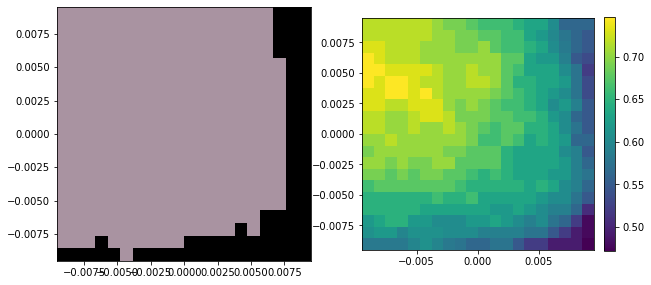

In [5]:
c = config.Config().load('demo_gold_blind_search_0.yml') # read configuration file, create a configuration class:
print(c)                                                 # show new parameters
S.load_config(c)                                         # input new config into reconstructor S.
S.serial_recon_multi_stage()                             # run reconstruction.
MicFileTool.plot_mic_and_conf(S.squareMicData, 0.6)      # show voxels with hit_ratio > 0.6

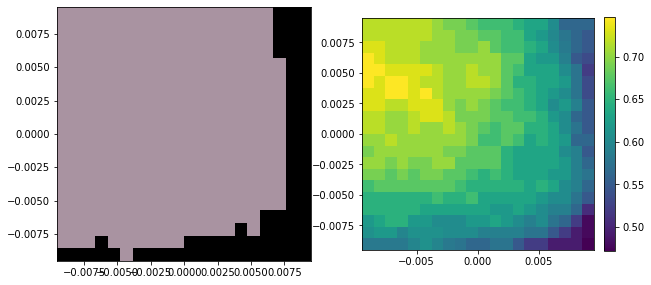

In [6]:
MicFileTool.plot_mic_and_conf(S.squareMicData, 0.6)      # show voxels with hit_ratio > 0.6

In [ ]:
#help(S.auto_twiddle)
S.auto_twiddle(0.8)

cnt: 0, current threhold is 0.6899999999999997
 loss: 0.2466, sumdp: 0.0720, L: [[4.5117 6.5117]], J: 1009.09 1025.17, K: 2015.44 2012.03...   .8673 349.6657]
 loss: 0.2294, sumdp: 0.0603, L: [[4.5117 6.5117]], J: 1009.09 1025.17, K: 2015.44 2013.83...   .7014 349.6138]
Niter: 00, vIdx: 0000013, prog: 0000000/0000400, conf: 0.760563, pkcnt: 71, euler: [ 40.3352  38.8806 349.5504]

In [ ]:
MicFileTool.plot_mic_and_conf(S.squareMicData, 0.85)

## reconstruct complete gold sample:


In [ ]:
c = config.Config().load('demo_gold_twiddle_0.yml')
c.micsize = [20, 20]
c.micVoxelSize = 0.005
print(c)
S.load_config(c)
S.serial_recon_multi_stage() 
################# visualization #########################
MicFileTool.plot_mic_and_conf(S.squareMicData, 0.5)  # show reconstruction result.

In [ ]:
MicFileTool.plot_mic_and_conf(S.squareMicData, 0.7)

# reconstruct iron dataset

In [ ]:
# step 1: reduce binray data set for fast initial guess

# fnbase = '/home/hedm/work/suter_aug18/SB1_v1_v2_boxbeam/SB1_postheat_restart_z0_'

# output = fnbase

# ImagePar={'nDetectors':2,
#         'sBinFilePrefix':'/home/hedm/work/suter_aug18/SB1_v1_v2_boxbeam/SB1_postheat_restart_V1/SB1_postheat_restart_V1__z0_',
#         'nReductionNSUM':4,
#         'nBinFileIndexStart':0,
#         'fOmegaStart':-90,
#         'fOmegaStop':90,
#         }
# IntBin.IntegrateBinFiles(ImagePar,output)

In [ ]:
# check binary
rawInitial = '../examples/johnson_aug18_demo/SB1_postheat_restart_V1_1degree/SB1_V1_1degree_z'
NRot = 3   # only number of images to display, doen't have to be all images(no need set to 180 or 720.can be some thing like 10)
NDet = 2
idxLayer = 0
# %matplotlib inline
# plt.rcParams["figure.figsize"] = (15,10)
MicFileTool.plot_binary(rawInitial, NRot=180, NDet=2, idxRot=0,idxLayer=0)

In [ ]:
'''
    Reconstruct sample SB with parameters from gold sample
'''
c_Au = config.Config().load('demo_gold_twiddle_0.yml')

Fe_Config={
    'micsize' : np.array([150, 150]),
    'micVoxelSize' : 0.01,
    'micShift' : np.array([0.0, 0.0, 0.0]),
    'expdataNDigit' : 6,
    'energy' : 65.351,      #55.587 # in kev
    'sample' : 'iron_bcc',
    'maxQ' : 9,
    'etalimit' : 81 / 180.0 * np.pi,
    'NRot' : 180,
    'NDet' : 2,
    'searchBatchSize' : 6000,
    'reverseRot' : True,          # for aero, is True, for rams: False
    'detNJ': np.array([2048, 2048]),
    'detNK': np.array([2048, 2048]),
    'detPixelJ': np.array([0.00148, 0.00148]),
    'detPixelK': np.array([0.00148, 0.00148]),
    'detL' : c_Au.detL,
    'detJ' : c_Au.detJ,
    'detK' : c_Au.detK,
    'detRot' : c_Au.detRot,
    'fileBin' : '../examples/johnson_aug18_demo/SB1_postheat_restart_V1_1degree/SB1_V1_1degree_z',
    'fileBinDigit' : 6,
    'fileBinDetIdx' : np.array([0, 1]),
    'fileBinLayerIdx' : 0,
    '_initialString' : '../examples/johnson_aug18_demo/SB1_postheat_restart_V1_1degree'}
  
c = config.Config(**Fe_Config)
print(c)
c.save('SB1_postheat_restart_V1_1degree_config.yml')

In [ ]:
S.load_config(c)
S.serial_recon_multi_stage()
################# visualization #########################
MicFileTool.plot_mic_and_conf(S.squareMicData, 0.5)

In [ ]:
MicFileTool.plot_mic_and_conf(S.squareMicData, 0.5)

## demonstrate using a mask

In [ ]:
# # step 2: start reconstruction with calibrated configuration (parameters)
# import reconstruction
# import MicFileTool
# import numpy as np
# import matplotlib.pyplot as plt
# import IntBin
# import pickle
# import scipy.ndimage as ndi
# # check result of parameter get from blind search:
# # NOET: in practice, might need more iterations for better configuration params
# with open('geometry_au_johnson_aug18_twiddle_1.p', 'rb') as input:
#     centerL, centerJ, centerK, centerRot  = pickle.load(input)

# ############ low resolution reconstruction
# S = reconstruction.Reconstructor_GPU()
# S.set_det_param(centerL, centerJ, centerK, centerRot) # set parameter
# S.set_Q(7)
# print(S.maxQ)

# S.FZFile = '/home/hedm/work/I9_test_data/Au_Mar17/DataFiles/MyFZ.dat'         # fundamental zone file
# S.set_sample('iron_bcc')
# S.energy = 65.351
# S.expDataInitial = '/home/hedm/work/suter_aug18/SB1_v1_v2_boxbeam/SB1_postheat_restart_V1_1degree/SB1_V1_1degree_z0_' # reduced binary data
# S.expdataNDigit = 6                                                       # number of digit in the binary file name
# imgsize = [15, 15]
# voxelSize = 0.1
# shift = [0.0, 0.0, 0.0]
# S.create_square_mic(imgsize,
#                     voxelsize=voxelSize,
#                     shift=shift,
#                    )# resolution of reconstruction and voxel size
# S.squareMicOutFile = 'demoSB1_V1_Z0_johnson_aug17_' \
#                     + f'{"x".join(map(str,imgsize))}_{voxelSize}' \
#                     + f'_shift_{"_".join(map(str, shift))}.npy' # output file name
# S.searchBatchSize = 6000   # number of orientations search at each iteration, larger number will take longer time.
# S.intensity_threshold = 2 # throw away peaks with intensity below this value
# S.recon_prepare(reverseRot=True)  # at 1ID, left hand rotation needs reverseRot=True
# S.serial_recon_multi_stage()

# #388seconds with verbose
# plt.rcParams["figure.figsize"] = (10,10)
# MicFileTool.plot_square_mic(S.squareMicData,0.6)
# MicFileTool.plot_conf_square_mic(S.squareMicData)

# ######### create mask
# mask_15_15 = np.load(S.squareMicOutFile)[:,:,6]>0.3
# #mask_30_30 = S.squareMicData[:,:,6]>0.5
# mask_150_15 = np.repeat(mask_15_15, 10, axis=0)
# mask_150_150 = np.repeat(mask_150_15, 10, axis=1)
# mask_150_150 = ndi.maximum_filter(mask_150_150,size=5)
# plt.imshow(mask_150_150.T, origin='lower')

# ######## high resolution reconstruction
# S = reconstruction.Reconstructor_GPU()
# S.set_det_param(centerL, centerJ, centerK, centerRot) # set parameter
# S.set_Q(7)
# print(S.maxQ)

# S.FZFile = '/home/hedm/work/I9_test_data/Au_Mar17/DataFiles/MyFZ.dat'         # fundamental zone file
# S.set_sample('iron_bcc')
# S.energy = 65.351
# S.expDataInitial = '/home/hedm/work/suter_aug18/SB1_v1_v2_boxbeam/SB1_postheat_restart_V1_1degree/SB1_V1_1degree_z0_' # reduced binary data
# S.expdataNDigit = 6 
# imgsize = [150, 150]
# voxelSize = 0.01
# shift = [0.0, 0.0, 0.0]
# S.create_square_mic(imgsize,
#                     voxelsize=voxelSize,
#                     shift=shift,
#                     mask=mask_150_150,
#                    )# resolution of reconstruction and voxel size
# S.squareMicOutFile = 'demoSB1_V1_Z0_johnson_aug17_' \
#                     + f'{"x".join(map(str,imgsize))}_{voxelSize}' \
#                     + f'_shift_{"_".join(map(str, shift))}.npy' # output file name
# S.searchBatchSize = 6000   # number of orientations search at each iteration, larger number will take longer time.
# S.intensity_threshold = 2 # throw away peaks with intensity below this value
# S.recon_prepare(reverseRot=True)  # at 1ID, left hand rotation needs reverseRot=True
# S.serial_recon_multi_stage()

# #388seconds with verbose
# plt.rcParams["figure.figsize"] = (10,10)
# MicFileTool.plot_square_mic(S.squareMicData,0.6)
# MicFileTool.plot_conf_square_mic(S.squareMicData)

In [ ]:
# import scipy.ndimage as ndi
# plt.imshow(mask_150_150)
# plt.show()
# mask_150_150_ = ndi.maximum_filter(mask_150_150,size=10)
# plt.imshow(mask_150_150_)
# plt.show()

In [ ]:
#http://rruff.geo.arizona.edu/AMS/periodictable.php